# Dynamic & Static Hand Movement Differentiation

## Capture Dynamic & Static Data

Capture sessions of dynamic and static signs for displacement analysis

In [18]:
import cv2 as cv
import mediapipe as mp
import numpy as np
import copy
import time
import random

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5
)

def calc_landmark_list(image, landmarks):
    """Extract landmark coordinates."""
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []
    for landmark in landmarks.landmark:
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point.append([landmark_x, landmark_y])
    return landmark_point

def pre_process_landmark(landmark_list):
    """Normalize landmarks to relative coordinates."""
    import itertools
    temp_landmark_list = copy.deepcopy(landmark_list)
    
    base_x, base_y = temp_landmark_list[0][0], temp_landmark_list[0][1]
    for index, landmark_point in enumerate(temp_landmark_list):
        temp_landmark_list[index][0] -= base_x
        temp_landmark_list[index][1] -= base_y
    
    temp_landmark_list = list(itertools.chain.from_iterable(temp_landmark_list))
    max_value = max(list(map(abs, temp_landmark_list)))
    temp_landmark_list = list(map(lambda n: n / max_value, temp_landmark_list))
    
    return temp_landmark_list

# Data collection setup
SESSION_DURATION = 1.5

# Dynamic letters (3 samples each)
dynamic_letters = ['H', 'J', 'U', 'X', 'Z'] * 3

# Static letters (15 samples)
static_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']

# Combine and shuffle
all_sessions = []
for letter in dynamic_letters:
    all_sessions.append({'letter': letter, 'mode': 'dynamic'})
for letter in static_letters:
    all_sessions.append({'letter': letter, 'mode': 'static'})

random.shuffle(all_sessions)

cap = cv.VideoCapture(0)
collected_data = []
current_session_index = 0
recording = False
session_start_time = None

print(f"Data Collection with Wrist Tracking - {len(all_sessions)} sessions")
print("Press 'R' to start next session")
print("Press 'X' to quit and save")

while current_session_index < len(all_sessions):
    ret, image = cap.read()
    if not ret:
        break
    
    image = cv.flip(image, 1)
    debug_image = copy.deepcopy(image)
    image_width, image_height = image.shape[1], image.shape[0]
    
    current_letter = all_sessions[current_session_index]['letter']
    current_mode = all_sessions[current_session_index]['mode']
    
    # Check if session time expired
    if recording and session_start_time:
        elapsed = time.time() - session_start_time
        if elapsed >= SESSION_DURATION:
            recording = False
            session_start_time = None
            current_session_index += 1
            print(f"Session complete! ({current_session_index}/{len(all_sessions)})")
            if current_session_index >= len(all_sessions):
                print("All sessions complete!")
                break
            continue
    
    # Process frame if recording
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if recording and results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_list = calc_landmark_list(debug_image, hand_landmarks)
            
            # Store raw wrist position (absolute coordinates)
            raw_wrist_x = landmark_list[0][0]
            raw_wrist_y = landmark_list[0][1]
            
            # Also store normalized wrist in 0-1 range
            norm_wrist_x = raw_wrist_x / image_width
            norm_wrist_y = raw_wrist_y / image_height
            
            # Get normalized landmarks for model
            processed = pre_process_landmark(landmark_list)
            
            collected_data.append({
                'landmarks': processed,
                'wrist_x': norm_wrist_x,
                'wrist_y': norm_wrist_y,
                'letter': current_letter,
                'mode': current_mode,
                'session': current_session_index
            })
    
    # Draw UI
    cv.rectangle(debug_image, (5, 5), (500, 220), (255, 255, 255), -1)
    
    progress_text = f"Session: {current_session_index + 1}/{len(all_sessions)}"
    cv.putText(debug_image, progress_text, (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    
    letter_text = f"Sign: {current_letter}"
    cv.putText(debug_image, letter_text, (10, 90),
               cv.FONT_HERSHEY_SIMPLEX, 2.0, (0, 0, 0), 3)
    
    mode_text = f"Type: {current_mode}"
    cv.putText(debug_image, mode_text, (10, 140),
               cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    
    if recording:
        elapsed = time.time() - session_start_time
        remaining = SESSION_DURATION - elapsed
        timer_text = f"Recording: {remaining:.1f}s"
        cv.putText(debug_image, timer_text, (10, 180),
                   cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        cv.circle(debug_image, (debug_image.shape[1] - 40, 40), 20, (0, 0, 255), -1)
        cv.putText(debug_image, "REC", (debug_image.shape[1] - 70, 80),
                   cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    else:
        cv.putText(debug_image, "Press R to start", (10, 180),
                   cv.FONT_HERSHEY_SIMPLEX, 0.8, (100, 100, 100), 2)
    
    frames_text = f"Frames: {len(collected_data)}"
    cv.putText(debug_image, frames_text, (10, 210),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
    
    cv.imshow('Data Collection - Wrist Tracking', debug_image)
    
    key = cv.waitKey(1) & 0xFF
    
    if key == ord('r') and not recording:
        recording = True
        session_start_time = time.time()
        print(f"Recording {current_letter} ({current_mode})...")
    elif key == ord('x'):
        print("Quitting early...")
        break

cap.release()
cv.destroyAllWindows()

# Save collected data
np.save('motion_wrist_tracked_data.npy', collected_data, allow_pickle=True)
print(f"\nSaved {len(collected_data)} total frames from {current_session_index} sessions")

static_count = sum(1 for d in collected_data if d['mode'] == 'static')
dynamic_count = sum(1 for d in collected_data if d['mode'] == 'dynamic')
print(f"Static frames: {static_count}")
print(f"Dynamic frames: {dynamic_count}")

I0000 00:00:1768992010.296429       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2


Data Collection with Wrist Tracking - 30 sessions
Press 'R' to start next session
Press 'X' to quit and save


KeyboardInterrupt: 

## Analyze Collected Data

Calculate and plot the differences between static and dynamic signs.



Loaded 865 total frames
Total sessions: 30

Static sessions: 15
Dynamic sessions: 15

H letter analysis (10 frames):
  total_disp=2.83, wrist_disp=0.3163, wrist_y=0.2861
  total_disp=2.27, wrist_disp=0.2749, wrist_y=0.2426
  total_disp=3.01, wrist_disp=0.3394, wrist_y=0.3139

--- STATIC SESSIONS ---
total_displacement: mean=1.46, max=5.04
wrist_displacement: mean=0.0153, max=0.0293
wrist_y_disp: mean=0.0094, max=0.0167

--- DYNAMIC SESSIONS ---
total_displacement: mean=16.01, min=2.27
wrist_displacement: mean=0.1451, min=0.0605
wrist_y_disp: mean=0.1058, min=0.0287


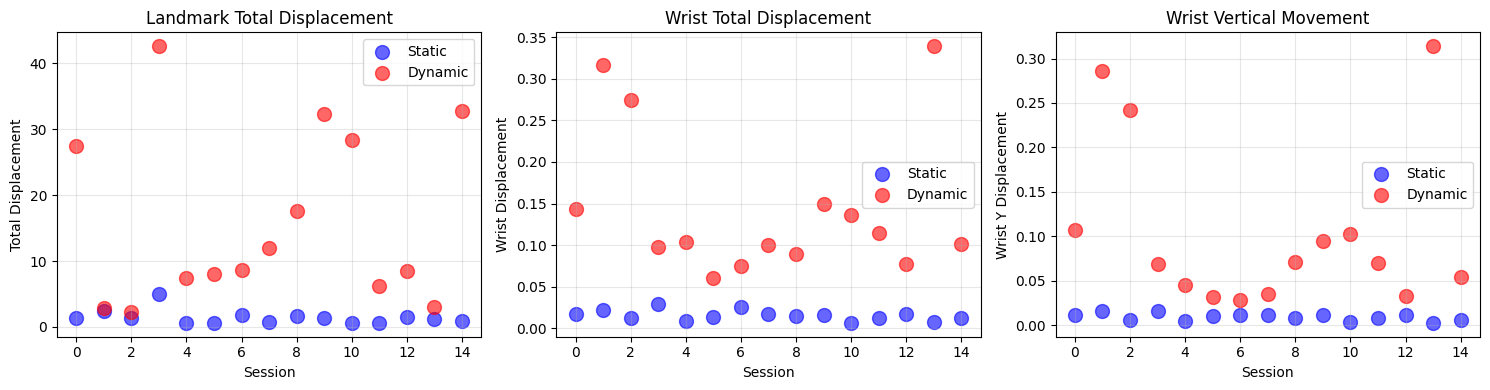

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def compute_motion_features(landmark_buffer):
    """Compute motion features from normalized landmark frames."""
    if len(landmark_buffer) < 2:
        return {'total_displacement': 0.0, 'max_displacement': 0.0, 'variance': 0.0}
    
    landmarks_array = np.array(landmark_buffer)
    diffs = np.diff(landmarks_array, axis=0)
    
    total_displacement = np.sum(np.abs(diffs))
    max_displacement = np.max(np.abs(diffs))
    variance = np.var(landmarks_array)
    
    return {
        'total_displacement': total_displacement,
        'max_displacement': max_displacement,
        'variance': variance
    }

def compute_wrist_motion(wrist_positions):
    """
    Compute wrist motion from absolute positions.
    
    Args:
        wrist_positions: list of [wrist_x, wrist_y] normalized coordinates (0-1 range)
    
    Returns:
        dict with wrist motion metrics
    """
    if len(wrist_positions) < 2:
        return {'wrist_displacement': 0.0, 'wrist_x_disp': 0.0, 'wrist_y_disp': 0.0}
    
    wrist_array = np.array(wrist_positions)
    wrist_diffs = np.diff(wrist_array, axis=0)
    
    wrist_displacement = np.sum(np.abs(wrist_diffs))
    wrist_x_disp = np.sum(np.abs(wrist_diffs[:, 0]))
    wrist_y_disp = np.sum(np.abs(wrist_diffs[:, 1]))
    
    return {
        'wrist_displacement': wrist_displacement,
        'wrist_x_disp': wrist_x_disp,
        'wrist_y_disp': wrist_y_disp
    }

# Load data
data = np.load('motion_wrist_tracked_data.npy', allow_pickle=True)
print(f"Loaded {len(data)} total frames")

# Group by session
sessions = {}
for frame in data:
    session_id = frame['session']
    if session_id not in sessions:
        sessions[session_id] = {
            'landmarks': [],
            'wrist_positions': [],
            'mode': frame['mode'],
            'letter': frame['letter']
        }
    sessions[session_id]['landmarks'].append(frame['landmarks'])
    sessions[session_id]['wrist_positions'].append([frame['wrist_x'], frame['wrist_y']])

print(f"Total sessions: {len(sessions)}")

# Analyze each session with 10-frame window
session_results = []
for session_id, session_data in sessions.items():
    landmarks = session_data['landmarks']
    wrist_positions = session_data['wrist_positions']
    mode = session_data['mode']
    letter = session_data['letter']
    
    if len(landmarks) < 10:
        continue
    
    # Use first 10 frames
    landmark_features = compute_motion_features(landmarks[:10])
    wrist_features = compute_wrist_motion(wrist_positions[:10])
    
    session_results.append({
        'session': session_id,
        'letter': letter,
        'mode': mode,
        'frames': len(landmarks),
        'total_displacement': landmark_features['total_displacement'],
        'wrist_displacement': wrist_features['wrist_displacement'],
        'wrist_x_disp': wrist_features['wrist_x_disp'],
        'wrist_y_disp': wrist_features['wrist_y_disp']
    })

# Separate static and dynamic
static_sessions = [s for s in session_results if s['mode'] == 'static']
dynamic_sessions = [s for s in session_results if s['mode'] == 'dynamic']

print(f"\nStatic sessions: {len(static_sessions)}")
print(f"Dynamic sessions: {len(dynamic_sessions)}")

# Show H specifically
h_sessions = [s for s in session_results if s['letter'] == 'H']
print("\nH letter analysis (10 frames):")
for h in h_sessions:
    print(f"  total_disp={h['total_displacement']:.2f}, "
          f"wrist_disp={h['wrist_displacement']:.4f}, "
          f"wrist_y={h['wrist_y_disp']:.4f}")

# Summary statistics
print("\n--- STATIC SESSIONS ---")
print(f"total_displacement: mean={np.mean([s['total_displacement'] for s in static_sessions]):.2f}, "
      f"max={np.max([s['total_displacement'] for s in static_sessions]):.2f}")
print(f"wrist_displacement: mean={np.mean([s['wrist_displacement'] for s in static_sessions]):.4f}, "
      f"max={np.max([s['wrist_displacement'] for s in static_sessions]):.4f}")
print(f"wrist_y_disp: mean={np.mean([s['wrist_y_disp'] for s in static_sessions]):.4f}, "
      f"max={np.max([s['wrist_y_disp'] for s in static_sessions]):.4f}")

print("\n--- DYNAMIC SESSIONS ---")
print(f"total_displacement: mean={np.mean([s['total_displacement'] for s in dynamic_sessions]):.2f}, "
      f"min={np.min([s['total_displacement'] for s in dynamic_sessions]):.2f}")
print(f"wrist_displacement: mean={np.mean([s['wrist_displacement'] for s in dynamic_sessions]):.4f}, "
      f"min={np.min([s['wrist_displacement'] for s in dynamic_sessions]):.4f}")
print(f"wrist_y_disp: mean={np.mean([s['wrist_y_disp'] for s in dynamic_sessions]):.4f}, "
      f"min={np.min([s['wrist_y_disp'] for s in dynamic_sessions]):.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total displacement
axes[0].scatter(range(len(static_sessions)), [s['total_displacement'] for s in static_sessions], 
               c='blue', label='Static', s=100, alpha=0.6)
axes[0].scatter(range(len(dynamic_sessions)), [s['total_displacement'] for s in dynamic_sessions], 
               c='red', label='Dynamic', s=100, alpha=0.6)
axes[0].set_xlabel('Session')
axes[0].set_ylabel('Total Displacement')
axes[0].set_title('Landmark Total Displacement')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Wrist displacement
axes[1].scatter(range(len(static_sessions)), [s['wrist_displacement'] for s in static_sessions], 
               c='blue', label='Static', s=100, alpha=0.6)
axes[1].scatter(range(len(dynamic_sessions)), [s['wrist_displacement'] for s in dynamic_sessions], 
               c='red', label='Dynamic', s=100, alpha=0.6)
axes[1].set_xlabel('Session')
axes[1].set_ylabel('Wrist Displacement')
axes[1].set_title('Wrist Total Displacement')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Wrist Y displacement
axes[2].scatter(range(len(static_sessions)), [s['wrist_y_disp'] for s in static_sessions], 
               c='blue', label='Static', s=100, alpha=0.6)
axes[2].scatter(range(len(dynamic_sessions)), [s['wrist_y_disp'] for s in dynamic_sessions], 
               c='red', label='Dynamic', s=100, alpha=0.6)
axes[2].set_xlabel('Session')
axes[2].set_ylabel('Wrist Y Displacement')
axes[2].set_title('Wrist Vertical Movement')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
# Test classification with combined metrics
print("=== CLASSIFICATION WITH WRIST TRACKING ===\n")

# Test different threshold combinations
total_disp_threshold = 10.0
wrist_disp_threshold = 0.04

correct = 0
misclassified = []

for session in session_results:
    # Classify as dynamic if EITHER threshold exceeded
    predicted_dynamic = (session['total_displacement'] > total_disp_threshold or 
                        session['wrist_displacement'] > wrist_disp_threshold)
    actual_dynamic = session['mode'] == 'dynamic'
    
    if predicted_dynamic == actual_dynamic:
        correct += 1
    else:
        misclassified.append(
            f"{session['letter']}({session['mode']}, "
            f"total={session['total_displacement']:.2f}, "
            f"wrist={session['wrist_displacement']:.4f})"
        )

accuracy = correct / len(session_results)
print(f"Combined threshold accuracy: {correct}/{len(session_results)} = {accuracy:.1%}")
print(f"Thresholds: total_disp > {total_disp_threshold}, wrist_disp > {wrist_disp_threshold}")

if misclassified:
    print("\nMisclassified:")
    for m in misclassified:
        print(f"  {m}")

# Check H detection specifically
print("\nH letter detection:")
for session in session_results:
    if session['letter'] == 'H':
        predicted = (session['total_displacement'] > total_disp_threshold or 
                    session['wrist_displacement'] > wrist_disp_threshold)
        status = "DETECTED" if predicted else "MISSED"
        print(f"  {status}: total={session['total_displacement']:.2f}, "
              f"wrist={session['wrist_displacement']:.4f}")

# Find optimal wrist threshold
static_wrist = [s['wrist_displacement'] for s in static_sessions]
dynamic_wrist = [s['wrist_displacement'] for s in dynamic_sessions]

max_static_wrist = np.max(static_wrist)
min_dynamic_wrist = np.min(dynamic_wrist)
optimal_wrist_threshold = (max_static_wrist + min_dynamic_wrist) / 2

print(f"\nWrist displacement analysis:")
print(f"  Static max: {max_static_wrist:.4f}")
print(f"  Dynamic min: {min_dynamic_wrist:.4f}")
print(f"  Optimal threshold: {optimal_wrist_threshold:.4f}")
print(f"  Gap: {min_dynamic_wrist - max_static_wrist:.4f}")

=== CLASSIFICATION WITH WRIST TRACKING ===

Combined threshold accuracy: 30/30 = 100.0%
Thresholds: total_disp > 10.0, wrist_disp > 0.04

H letter detection:
  DETECTED: total=2.83, wrist=0.3163
  DETECTED: total=2.27, wrist=0.2749
  DETECTED: total=3.01, wrist=0.3394

Wrist displacement analysis:
  Static max: 0.0293
  Dynamic min: 0.0605
  Optimal threshold: 0.0449
  Gap: 0.0312


In [6]:
def compute_motion_features_with_wrist(landmark_buffer, wrist_positions):
    """
    Compute combined motion features.
    
    Args:
        landmark_buffer: list of normalized landmarks (42 values each)
        wrist_positions: list of [wrist_x, wrist_y] normalized coords
    
    Returns:
        dict with motion metrics and classification
    """
    if len(landmark_buffer) < 2 or len(wrist_positions) < 2:
        return {
            'is_dynamic': False,
            'total_displacement': 0.0,
            'wrist_displacement': 0.0,
            'confidence': 'low'
        }
    
    # Landmark displacement
    landmarks_array = np.array(landmark_buffer)
    diffs = np.diff(landmarks_array, axis=0)
    total_displacement = np.sum(np.abs(diffs))
    
    # Wrist displacement
    wrist_array = np.array(wrist_positions)
    wrist_diffs = np.diff(wrist_array, axis=0)
    wrist_displacement = np.sum(np.abs(wrist_diffs))
    
    # Classification with dual thresholds
    TOTAL_DISP_THRESHOLD = 10.0
    WRIST_DISP_THRESHOLD = 0.04
    
    is_dynamic = (total_displacement > TOTAL_DISP_THRESHOLD or 
                  wrist_displacement > WRIST_DISP_THRESHOLD)
    
    # Confidence based on how far from thresholds
    if is_dynamic:
        # How much over threshold
        total_margin = total_displacement - TOTAL_DISP_THRESHOLD
        wrist_margin = wrist_displacement - WRIST_DISP_THRESHOLD
        max_margin = max(total_margin, wrist_margin)
        
        if max_margin > 5.0:
            confidence = 'high'
        elif max_margin > 2.0:
            confidence = 'medium'
        else:
            confidence = 'low'
    else:
        # How much under threshold
        total_margin = TOTAL_DISP_THRESHOLD - total_displacement
        wrist_margin = WRIST_DISP_THRESHOLD - wrist_displacement
        min_margin = min(total_margin, wrist_margin)
        
        if min_margin > 3.0:
            confidence = 'high'
        elif min_margin > 1.0:
            confidence = 'medium'
        else:
            confidence = 'low'
    
    return {
        'is_dynamic': is_dynamic,
        'total_displacement': total_displacement,
        'wrist_displacement': wrist_displacement,
        'confidence': confidence
    }

# Smoke test
print("=== SMOKE TEST ===\n")

# Test with actual session data
for session in session_results:
    # Simulate with first 10 frames
    session_data = sessions[session['session']]
    landmarks = session_data['landmarks'][:10]
    wrists = session_data['wrist_positions'][:10]
    
    result = compute_motion_features_with_wrist(landmarks, wrists)
    
    print(f"{session['letter']} ({session['mode']}): "
          f"predicted={'dynamic' if result['is_dynamic'] else 'static'}, "
          f"confidence={result['confidence']}, "
          f"total={result['total_displacement']:.2f}, "
          f"wrist={result['wrist_displacement']:.4f}")

=== SMOKE TEST ===

J (dynamic): predicted=dynamic, confidence=high, total=27.42, wrist=0.1428
E (static): predicted=static, confidence=low, total=1.30, wrist=0.0174
C (static): predicted=static, confidence=low, total=2.41, wrist=0.0219
A (static): predicted=static, confidence=low, total=1.28, wrist=0.0117
G (static): predicted=static, confidence=low, total=5.04, wrist=0.0293
I (static): predicted=static, confidence=low, total=0.65, wrist=0.0083
H (dynamic): predicted=dynamic, confidence=low, total=2.83, wrist=0.3163
H (dynamic): predicted=dynamic, confidence=low, total=2.27, wrist=0.2749
K (static): predicted=static, confidence=low, total=0.65, wrist=0.0138
Q (static): predicted=static, confidence=low, total=1.88, wrist=0.0256
L (static): predicted=static, confidence=low, total=0.76, wrist=0.0168
J (dynamic): predicted=dynamic, confidence=high, total=42.62, wrist=0.0977
Z (dynamic): predicted=dynamic, confidence=low, total=7.36, wrist=0.1032
O (static): predicted=static, confidence=lo

## Rolling Window Detector


In [9]:
from collections import deque

class RollingMotionDetector:
    """
    Continuously monitors hand motion using rolling windows.
    Detects when a sign (static or dynamic) is complete.
    """
    
    def __init__(self, window_size=10, detection_frames=20):
        """
        Args:
            window_size: frames per analysis window
            detection_frames: min frames before making static classification
        """
        self.window_size = window_size
        self.detection_frames = detection_frames
        self.landmark_buffer = deque(maxlen=50)  # Keep last 50 frames
        self.wrist_buffer = deque(maxlen=50)
        self.high_motion_detected = False
        self.frames_since_start = 0
        
    def add_frame(self, landmarks, wrist_position):
        """
        Add a new frame to the buffer.
        
        Args:
            landmarks: normalized landmarks (42 values)
            wrist_position: [wrist_x, wrist_y] normalized coords
        """
        self.landmark_buffer.append(landmarks)
        self.wrist_buffer.append(wrist_position)
        self.frames_since_start += 1
    
    def check_motion(self):
        """
        Analyze current buffer and return detection result.
        
        Returns:
            dict with detection result or None if not ready
        """
        if len(self.landmark_buffer) < self.window_size:
            return None
        
        # Analyze most recent window
        recent_landmarks = list(self.landmark_buffer)[-self.window_size:]
        recent_wrists = list(self.wrist_buffer)[-self.window_size:]
        
        features = compute_motion_features_with_wrist(recent_landmarks, recent_wrists)
        
        # If we detect dynamic motion, classify immediately
        if features['is_dynamic']:
            self.high_motion_detected = True
            return {
                'is_dynamic': True,
                'confidence': features['confidence'],
                'total_displacement': features['total_displacement'],
                'wrist_displacement': features['wrist_displacement'],
                'frames_analyzed': self.frames_since_start
            }
        
        # For static, wait for minimum frames
        if self.frames_since_start >= self.detection_frames:
            return {
                'is_dynamic': False,
                'confidence': features['confidence'],
                'total_displacement': features['total_displacement'],
                'wrist_displacement': features['wrist_displacement'],
                'frames_analyzed': self.frames_since_start
            }
        
        return None
    
    def reset(self):
        """Reset detector for new sign."""
        self.landmark_buffer.clear()
        self.wrist_buffer.clear()
        self.high_motion_detected = False
        self.frames_since_start = 0

# Test with session data
print("=== ROLLING DETECTOR TEST ===\n")

for session_id in list(sessions.keys())[:10]:
    session_data = sessions[session_id]
    landmarks = session_data['landmarks']
    wrists = session_data['wrist_positions']
    letter = session_data['letter']
    mode = session_data['mode']
    
    detector = RollingMotionDetector(window_size=10, detection_frames=20)
    
    detection_result = None
    for i, (landmark, wrist) in enumerate(zip(landmarks, wrists)):
        detector.add_frame(landmark, wrist)
        result = detector.check_motion()
        if result:
            detection_result = result
            detected_frame = i + 1
            break
    
    if detection_result:
        predicted = 'dynamic' if detection_result['is_dynamic'] else 'static'
        correct = predicted == mode
        status = "CORRECT" if correct else "WRONG"
        
        print(f"{status}: {letter} ({mode}) -> predicted {predicted}")
        print(f"  Detected at frame {detected_frame}, "
              f"confidence={detection_result['confidence']}, "
              f"total_disp={detection_result['total_displacement']:.2f}, "
              f"wrist_disp={detection_result['wrist_displacement']:.4f}\n")

=== ROLLING DETECTOR TEST ===

CORRECT: J (dynamic) -> predicted dynamic
  Detected at frame 10, confidence=high, total_disp=27.42, wrist_disp=0.1428

CORRECT: E (static) -> predicted static
  Detected at frame 20, confidence=low, total_disp=1.54, wrist_disp=0.0136

WRONG: C (static) -> predicted dynamic
  Detected at frame 19, confidence=low, total_disp=3.28, wrist_disp=0.0443

CORRECT: A (static) -> predicted static
  Detected at frame 20, confidence=low, total_disp=1.03, wrist_disp=0.0105

CORRECT: G (static) -> predicted static
  Detected at frame 20, confidence=low, total_disp=3.19, wrist_disp=0.0211

CORRECT: I (static) -> predicted static
  Detected at frame 20, confidence=low, total_disp=0.71, wrist_disp=0.0072

CORRECT: H (dynamic) -> predicted dynamic
  Detected at frame 10, confidence=low, total_disp=2.83, wrist_disp=0.3163

CORRECT: H (dynamic) -> predicted dynamic
  Detected at frame 10, confidence=low, total_disp=2.27, wrist_disp=0.2749

CORRECT: K (static) -> predicted s

In [11]:
print("=== FULL ROLLING DETECTOR ACCURACY TEST ===\n")

correct = 0
total = 0
misclassified = []

for session_id, session_data in sessions.items():
    landmarks = session_data['landmarks']
    wrists = session_data['wrist_positions']
    letter = session_data['letter']
    mode = session_data['mode']
    
    detector = RollingMotionDetector(window_size=10, detection_frames=20)
    
    detection_result = None
    for landmark, wrist in zip(landmarks, wrists):
        detector.add_frame(landmark, wrist)
        result = detector.check_motion()
        if result:
            detection_result = result
            break
    
    if detection_result:
        predicted = 'dynamic' if detection_result['is_dynamic'] else 'static'
        
        if predicted == mode:
            correct += 1
        else:
            misclassified.append({
                'letter': letter,
                'actual': mode,
                'predicted': predicted,
                'total_disp': detection_result['total_displacement'],
                'wrist_disp': detection_result['wrist_displacement']
            })
        total += 1

accuracy = correct / total if total > 0 else 0
print(f"Overall accuracy: {correct}/{total} = {accuracy:.1%}\n")

if misclassified:
    print("Misclassified sessions:")
    for m in misclassified:
        print(f"  {m['letter']} (actual={m['actual']}, predicted={m['predicted']})")
        print(f"    total_disp={m['total_disp']:.2f}, wrist_disp={m['wrist_disp']:.4f}")

# Show detection timing statistics
print("\n=== DETECTION TIMING ===")

dynamic_times = []
static_times = []

for session_id, session_data in sessions.items():
    landmarks = session_data['landmarks']
    wrists = session_data['wrist_positions']
    mode = session_data['mode']
    
    detector = RollingMotionDetector(window_size=10, detection_frames=20)
    
    for i, (landmark, wrist) in enumerate(zip(landmarks, wrists)):
        detector.add_frame(landmark, wrist)
        result = detector.check_motion()
        if result:
            detected_frame = i + 1
            if mode == 'dynamic':
                dynamic_times.append(detected_frame)
            else:
                static_times.append(detected_frame)
            break

print(f"Dynamic signs detected at frame: mean={np.mean(dynamic_times):.1f}, "
      f"min={np.min(dynamic_times)}, max={np.max(dynamic_times)}")
print(f"Static signs detected at frame: mean={np.mean(static_times):.1f}, "
      f"min={np.min(static_times)}, max={np.max(static_times)}")
print(f"\nAt 30 FPS:")
print(f"  Dynamic detection time: ~{np.mean(dynamic_times)/30:.2f}s")
print(f"  Static detection time: ~{np.mean(static_times)/30:.2f}s")

=== FULL ROLLING DETECTOR ACCURACY TEST ===

Overall accuracy: 29/30 = 96.7%

Misclassified sessions:
  C (actual=static, predicted=dynamic)
    total_disp=3.28, wrist_disp=0.0443

=== DETECTION TIMING ===
Dynamic signs detected at frame: mean=10.0, min=10, max=10
Static signs detected at frame: mean=19.9, min=19, max=20

At 30 FPS:
  Dynamic detection time: ~0.33s
  Static detection time: ~0.66s


## Proof of Concept


In [1]:
import cv2 as cv
import mediapipe as mp
import numpy as np
import copy
from collections import deque

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5
)

# Global thresholds (adjustable)
TOTAL_DISP_THRESHOLD = 10.0
WRIST_DISP_THRESHOLD = 0.04

def calc_landmark_list(image, landmarks):
    """Extract landmark coordinates."""
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []
    for landmark in landmarks.landmark:
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point.append([landmark_x, landmark_y])
    return landmark_point

def pre_process_landmark(landmark_list):
    """Normalize landmarks to relative coordinates."""
    import itertools
    temp_landmark_list = copy.deepcopy(landmark_list)
    
    base_x, base_y = temp_landmark_list[0][0], temp_landmark_list[0][1]
    for index, landmark_point in enumerate(temp_landmark_list):
        temp_landmark_list[index][0] -= base_x
        temp_landmark_list[index][1] -= base_y
    
    temp_landmark_list = list(itertools.chain.from_iterable(temp_landmark_list))
    max_value = max(list(map(abs, temp_landmark_list)))
    temp_landmark_list = list(map(lambda n: n / max_value, temp_landmark_list))
    
    return temp_landmark_list

def draw_landmarks(image, landmark_point):
    """Draw hand skeleton."""
    if len(landmark_point) == 0:
        return image
    
    # Thumb
    cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]), (255, 255, 255), 2)

    # Index finger
    cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]), (255, 255, 255), 2)

    # Middle finger
    cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]), (255, 255, 255), 2)

    # Ring finger
    cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]), (255, 255, 255), 2)

    # Pinky
    cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]), (255, 255, 255), 2)

    # Palm
    cv.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]), (255, 255, 255), 2)
    cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]), (0, 0, 0), 6)
    cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]), (255, 255, 255), 2)

    return image

def compute_motion_features_with_wrist(landmark_buffer, wrist_positions, 
                                       total_threshold, wrist_threshold):
    """Compute combined motion features with adjustable thresholds."""
    if len(landmark_buffer) < 2 or len(wrist_positions) < 2:
        return {
            'is_dynamic': False,
            'total_displacement': 0.0,
            'wrist_displacement': 0.0,
            'confidence': 'low'
        }
    
    # Landmark displacement
    landmarks_array = np.array(landmark_buffer)
    diffs = np.diff(landmarks_array, axis=0)
    total_displacement = np.sum(np.abs(diffs))
    
    # Wrist displacement
    wrist_array = np.array(wrist_positions)
    wrist_diffs = np.diff(wrist_array, axis=0)
    wrist_displacement = np.sum(np.abs(wrist_diffs))
    
    # Classification with thresholds
    is_dynamic = (total_displacement > total_threshold or 
                  wrist_displacement > wrist_threshold)
    
    # Confidence based on distance from thresholds
    if is_dynamic:
        total_margin = total_displacement - total_threshold
        wrist_margin = wrist_displacement - wrist_threshold
        max_margin = max(total_margin, wrist_margin)
        
        if max_margin > 5.0:
            confidence = 'high'
        elif max_margin > 2.0:
            confidence = 'medium'
        else:
            confidence = 'low'
    else:
        total_margin = total_threshold - total_displacement
        wrist_margin = wrist_threshold - wrist_displacement
        min_margin = min(total_margin, wrist_margin)
        
        if min_margin > 3.0:
            confidence = 'high'
        elif min_margin > 1.0:
            confidence = 'medium'
        else:
            confidence = 'low'
    
    return {
        'is_dynamic': is_dynamic,
        'total_displacement': total_displacement,
        'wrist_displacement': wrist_displacement,
        'confidence': confidence
    }

class RollingMotionDetector:
    """Continuously monitors hand motion using rolling windows."""
    
    def __init__(self, window_size=10, detection_frames=20):
        self.window_size = window_size
        self.detection_frames = detection_frames
        self.landmark_buffer = deque(maxlen=50)
        self.wrist_buffer = deque(maxlen=50)
        self.frames_since_start = 0
        
    def add_frame(self, landmarks, wrist_position):
        """Add a new frame to the buffer."""
        self.landmark_buffer.append(landmarks)
        self.wrist_buffer.append(wrist_position)
        self.frames_since_start += 1
    
    def check_motion(self, total_threshold, wrist_threshold):
        """Analyze current buffer and return detection result."""
        if len(self.landmark_buffer) < self.window_size:
            return None
        
        recent_landmarks = list(self.landmark_buffer)[-self.window_size:]
        recent_wrists = list(self.wrist_buffer)[-self.window_size:]
        
        features = compute_motion_features_with_wrist(recent_landmarks, recent_wrists,
                                                     total_threshold, wrist_threshold)
        
        if features['is_dynamic']:
            return {
                'is_dynamic': True,
                'confidence': features['confidence'],
                'total_displacement': features['total_displacement'],
                'wrist_displacement': features['wrist_displacement']
            }
        
        if self.frames_since_start >= self.detection_frames:
            return {
                'is_dynamic': False,
                'confidence': features['confidence'],
                'total_displacement': features['total_displacement'],
                'wrist_displacement': features['wrist_displacement']
            }
        
        return None
    
    def reset(self):
        """Reset detector for new sign."""
        self.landmark_buffer.clear()
        self.wrist_buffer.clear()
        self.frames_since_start = 0

def draw_status_box(image, status, confidence=None, details=None):
    """Draw status box in top right corner."""
    box_width = 280
    box_height = 120 if details else 90
    margin = 10
    x = image.shape[1] - box_width - margin
    y = margin
    
    # Semi-transparent background
    overlay = image.copy()
    cv.rectangle(overlay, (x, y), (x + box_width, y + box_height), (50, 50, 50), -1)
    cv.addWeighted(overlay, 0.7, image, 0.3, 0, image)
    
    # Border
    cv.rectangle(image, (x, y), (x + box_width, y + box_height), (200, 200, 200), 2)
    
    # Status color
    if status == 'No Hand Detected':
        status_color = (100, 100, 100)
    elif status == 'Dynamic':
        status_color = (0, 100, 255)
    elif status == 'Static':
        status_color = (0, 200, 0)
    else:
        status_color = (255, 255, 255)
    
    # Draw status text
    cv.putText(image, status, (x + 10, y + 30),
               cv.FONT_HERSHEY_SIMPLEX, 0.7, status_color, 2)
    
    # Draw confidence bar if available
    if confidence:
        bar_x = x + 10
        bar_y = y + 50
        bar_width = 260
        bar_height = 20
        
        # Background bar
        cv.rectangle(image, (bar_x, bar_y), (bar_x + bar_width, bar_y + bar_height), 
                    (80, 80, 80), -1)
        
        # Confidence fill
        if confidence == 'low':
            fill_width = int(bar_width * 0.33)
            bar_color = (0, 165, 255)
        elif confidence == 'medium':
            fill_width = int(bar_width * 0.66)
            bar_color = (0, 200, 200)
        else:
            fill_width = bar_width
            bar_color = (0, 255, 0)
        
        cv.rectangle(image, (bar_x, bar_y), (bar_x + fill_width, bar_y + bar_height), 
                    bar_color, -1)
        
        # Confidence text
        cv.putText(image, f"Confidence: {confidence}", (bar_x, bar_y + 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Draw details if provided
    if details:
        details_y = y + 85
        details_text = f"T:{details.get('total_disp', 0):.1f} W:{details.get('wrist_disp', 0):.3f}"
        cv.putText(image, details_text, (x + 10, details_y),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1)

def draw_threshold_controls(image, total_threshold, wrist_threshold):
    """Draw threshold adjustment controls in bottom left."""
    box_width = 320
    box_height = 80
    margin = 10
    x = margin
    y = image.shape[0] - box_height - margin
    
    # Semi-transparent background
    overlay = image.copy()
    cv.rectangle(overlay, (x, y), (x + box_width, y + box_height), (50, 50, 50), -1)
    cv.addWeighted(overlay, 0.7, image, 0.3, 0, image)
    
    # Border
    cv.rectangle(image, (x, y), (x + box_width, y + box_height), (200, 200, 200), 2)
    
    # Title
    cv.putText(image, "Thresholds (Q/A, W/S)", (x + 10, y + 20),
               cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Total displacement threshold
    cv.putText(image, f"Total Disp: {total_threshold:.1f}", (x + 10, y + 45),
               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 200, 200), 1)
    
    # Wrist displacement threshold
    cv.putText(image, f"Wrist Disp: {wrist_threshold:.3f}", (x + 10, y + 65),
               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 200, 200), 1)

# Main loop
cap = cv.VideoCapture(0)
detector = RollingMotionDetector(window_size=10, detection_frames=20)
current_detection = None

print("Motion Detection Demo")
print("Press ESC to quit")
print("Press 'D' to toggle debug mode")
print("\nDebug mode controls:")
print("  Q/A: Adjust total displacement threshold")
print("  W/S: Adjust wrist displacement threshold")

debug_mode = False

while True:
    ret, image = cap.read()
    if not ret:
        break
    
    image = cv.flip(image, 1)
    debug_image = copy.deepcopy(image)
    image_width, image_height = image.shape[1], image.shape[0]
    
    # Process frame
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_list = calc_landmark_list(debug_image, hand_landmarks)
            
            # Draw skeleton in debug mode
            if debug_mode:
                debug_image = draw_landmarks(debug_image, landmark_list)
            
            # Get raw wrist position
            wrist_x = landmark_list[0][0] / image_width
            wrist_y = landmark_list[0][1] / image_height
            
            # Get normalized landmarks
            processed = pre_process_landmark(landmark_list)
            
            # Add to detector
            detector.add_frame(processed, [wrist_x, wrist_y])
            
            # Check for detection
            result = detector.check_motion(TOTAL_DISP_THRESHOLD, WRIST_DISP_THRESHOLD)
            if result:
                current_detection = result
        
        # Draw status
        if current_detection:
            status = 'Dynamic' if current_detection['is_dynamic'] else 'Static'
            details = {
                'total_disp': current_detection['total_displacement'],
                'wrist_disp': current_detection['wrist_displacement']
            } if debug_mode else None
            
            draw_status_box(debug_image, status, current_detection['confidence'], details)
        else:
            draw_status_box(debug_image, 'Analyzing...', None, None)
    else:
        # No hand detected
        detector.reset()
        current_detection = None
        draw_status_box(debug_image, 'No Hand Detected', None, None)
    
    # Draw threshold controls in debug mode
    if debug_mode:
        draw_threshold_controls(debug_image, TOTAL_DISP_THRESHOLD, WRIST_DISP_THRESHOLD)
        
        # Debug mode indicator
        cv.putText(debug_image, "DEBUG MODE", (10, 30),
                   cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    cv.imshow('Motion Detection Demo', debug_image)
    
    key = cv.waitKey(1) & 0xFF
    if key == 27:
        break
    elif key == ord('d'):
        debug_mode = not debug_mode
        print(f"Debug mode: {'ON' if debug_mode else 'OFF'}")
    elif key == ord('q') and debug_mode:
        TOTAL_DISP_THRESHOLD += 0.5
        print(f"Total threshold: {TOTAL_DISP_THRESHOLD:.1f}")
    elif key == ord('a') and debug_mode:
        TOTAL_DISP_THRESHOLD = max(0.5, TOTAL_DISP_THRESHOLD - 0.5)
        print(f"Total threshold: {TOTAL_DISP_THRESHOLD:.1f}")
    elif key == ord('w') and debug_mode:
        WRIST_DISP_THRESHOLD += 0.005
        print(f"Wrist threshold: {WRIST_DISP_THRESHOLD:.3f}")
    elif key == ord('s') and debug_mode:
        WRIST_DISP_THRESHOLD = max(0.005, WRIST_DISP_THRESHOLD - 0.005)
        print(f"Wrist threshold: {WRIST_DISP_THRESHOLD:.3f}")

cap.release()
cv.destroyAllWindows()

print(f"\nFinal thresholds:")
print(f"  Total displacement: {TOTAL_DISP_THRESHOLD:.1f}")
print(f"  Wrist displacement: {WRIST_DISP_THRESHOLD:.3f}")

I0000 00:00:1768993541.949224       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Motion Detection Demo
Press ESC to quit
Press 'D' to toggle debug mode

Debug mode controls:
  Q/A: Adjust total displacement threshold
  W/S: Adjust wrist displacement threshold
Debug mode: ON
Total threshold: 10.5
Total threshold: 10.0
Total threshold: 9.5
Total threshold: 9.0
Total threshold: 8.5
Total threshold: 8.0
Total threshold: 7.5
Wrist threshold: 0.045
Wrist threshold: 0.050
Wrist threshold: 0.055
Wrist threshold: 0.060
Wrist threshold: 0.065
Wrist threshold: 0.070
Wrist threshold: 0.075
Wrist threshold: 0.080
Wrist threshold: 0.085
Wrist threshold: 0.090
Wrist threshold: 0.085
Wrist threshold: 0.080
Wrist threshold: 0.075
Wrist threshold: 0.070
Wrist threshold: 0.065
Wrist threshold: 0.060
Wrist threshold: 0.055
Wrist threshold: 0.050
Wrist threshold: 0.045
Wrist threshold: 0.040
Wrist threshold: 0.035
Wrist threshold: 0.030
Wrist threshold: 0.025
Wrist threshold: 0.020
Wrist threshold: 0.015
Wrist threshold: 0.010
Wrist threshold: 0.005
Wrist threshold: 0.010
Wrist thresho